In [1]:
import numpy as np
import pandas as pd
import vectorbt as vbt
import quantstats as qs
import matplotlib.pyplot as plt

from binance import Client
from binance.enums import HistoricalKlinesType

### 抓資料並切割樣本

In [2]:
#get binance data

client = Client()
value = client.get_historical_klines(symbol = 'BTCUSDT', 
                                      interval = '15m', 
                                      start_str = '2020-01-01', 
                                      end_str = '2023-06-30',
                                      klines_type=HistoricalKlinesType.FUTURES)

columns_name = ['openTime', 'Open', 'High', 'Low', 'Close', 'Volume', 'closeTime', 
                'quoteVolume', 'numTrade', 'takerBuyVolume', 'takerBuyQuoteVolume', 'ignore']

df = pd.DataFrame(value)
df.columns = columns_name
df['openTime']= pd.to_datetime(df['openTime'], unit='ms')
df = df.drop(['ignore', 'closeTime'], axis=1)
df = df.sort_values('openTime', ascending=True)
df = df.set_index('openTime')
df = df.astype(float)
df = df[~df.index.duplicated(keep='first')]

In [3]:
#split to in and out sample
price_all = df[['Open', 'High', 'Low', 'Close']]
price_is = price_all['2020-01-01':'2022-08-31'] # in sample data
price_os = price_all['2022-09-01':'2023-06-30'] # out sample data
print(price_all)
print(price_is)
print(price_os)

                         Open      High       Low     Close
openTime                                                   
2020-01-01 00:00:00   7189.43   7190.52   7172.94   7176.26
2020-01-01 00:15:00   7176.22   7179.41   7170.69   7172.36
2020-01-01 00:30:00   7172.79   7179.45   7170.61   7174.83
2020-01-01 00:45:00   7174.51   7179.36   7170.15   7171.55
2020-01-01 01:00:00   7171.43   7188.77   7171.10   7186.60
...                       ...       ...       ...       ...
2023-06-29 23:00:00  30402.50  30409.00  30380.00  30395.70
2023-06-29 23:15:00  30395.70  30476.00  30383.10  30472.00
2023-06-29 23:30:00  30472.10  30523.50  30460.00  30470.00
2023-06-29 23:45:00  30469.90  30470.00  30430.40  30439.90
2023-06-30 00:00:00  30439.90  30466.80  30408.00  30408.00

[122497 rows x 4 columns]
                         Open      High       Low     Close
openTime                                                   
2020-01-01 00:00:00   7189.43   7190.52   7172.94   7176.26
2020-01-01 00

### 定義策略

In [30]:
#double rsi as signal and filter
def ma_long(close, ma_window = 29, rsi_window = 50):

    sma = vbt.MA.run(close, window=ma_window)
    ema = vbt.MA.run(close, window=ma_window, ewm = True)

    #rsi = vbt.RSI.run(close, window=rsi_window).rsi

    signal = np.where(ema.ma_crossed_above(sma).to_numpy(), 1, 0)
    signal = np.where(ema.ma_crossed_below(sma).to_numpy(), -1, signal)

    return signal

MyInd = vbt.IndicatorFactory(
    class_name = 'ma_long',
    short_name = 'long',
    input_names = ['close'],
    param_names = ['ma_window', 'rsi_window'],
    output_names = ['signals'] 
).from_apply_func(ma_long, keep_pd=True)

In [56]:
#run strategy and do parameter optimization on in sample data

win = np.arange(10, 3000)
signal = MyInd.run(price_is['Close'] , ma_window=win, rsi_window=win, param_product = False)

entries = signal.signals == 1
exits = signal.signals == -1

portfolio = vbt.Portfolio.from_signals(
    price_is['Close'], 
    entries, 
    exits,
    freq = '15m', 
    direction = 'shortonly', 
    sl_stop = 0.03,
    fees = 0.0015
)

print(portfolio.total_return().sort_values())
print(portfolio.sharpe_ratio().sort_values())

long_ma_window  long_rsi_window
11              11                -0.999998
10              10                -0.999998
12              12                -0.999998
13              13                -0.999998
14              14                -0.999998
                                     ...   
1421            1421               0.916130
1407            1407               0.944621
1408            1408               0.979961
1428            1428               1.046789
1427            1427               1.190134
Name: total_return, Length: 2990, dtype: float64
long_ma_window  long_rsi_window
10              10                -10.450877
11              11                -10.121077
12              12                 -9.572011
14              14                 -9.548317
13              13                 -9.504432
                                     ...    
1421            1421                1.082067
1407            1407                1.107688
1428            1428                1.13776

In [51]:
pf = pd.concat([portfolio.total_return(),  portfolio.sharpe_ratio()], axis=1)

In [52]:
# 畫出參數高原
import plotly.graph_objects as go

x = pf.loc[pf['total_return'] > 0].index.get_level_values(0)
y = pf.loc[pf['total_return'] > 0].index.get_level_values(1)
z = pf.loc[pf['total_return'] > 0]['total_return']
data = (pf.loc[pf['total_return'] > 0]['sharpe_ratio'])
scatter_data = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        color=data,  # 将第四维数据用颜色表示
        colorscale='Viridis',
        colorbar=dict(title='Sharpe')  # 添加颜色条
    )
)

# 创建图布局
layout = go.Layout(
    title='3D Scatter Plot',
    scene=dict(
        xaxis=dict(title='rsi_window'),
        yaxis=dict(title='filter_window'),
        zaxis=dict(title='return')
    )
)

# 创建图像的 Figure 对象并绘制图像
fig = go.Figure(data=[scatter_data], layout=layout)
fig.show()
fig.write_html(file = '3d_plot.html' , auto_open  = True)#圖片儲存並自動展

In [53]:
#select strategies with best sharpe ratio
idx_best_10_sharpe = pf.loc[pf.index.get_level_values(0) > 25].sort_values(by = 'sharpe_ratio', ascending=False).index[0:10].to_list()
idx_best_10_return = pf.loc[pf.index.get_level_values(0) > 25].sort_values(by = 'total_return', ascending=False).index[0:10].to_list()
idx_best_5_sharpe = pf.loc[pf.index.get_level_values(0) > 25].sort_values(by = 'sharpe_ratio', ascending=False).index[0:5].to_list()
idx_best_5_return = pf.loc[pf.index.get_level_values(0) > 25].sort_values(by = 'total_return', ascending=False).index[0:5].to_list()
print("best 10 sharpe: " + str(idx_best_10_sharpe))
print("best 10 return: " + str(idx_best_10_return))

best 10 sharpe: [(1875, 1875), (2470, 2470), (1959, 1959), (1874, 1874), (2637, 2637), (2393, 2393), (2392, 2392), (1873, 1873), (1939, 1939), (1960, 1960)]
best 10 return: [(1875, 1875), (1959, 1959), (1939, 1939), (1960, 1960), (2393, 2393), (1874, 1874), (2392, 2392), (1873, 1873), (2470, 2470), (1899, 1899)]


In [54]:
entries_list = []
exits_list = []

idx = [(499, 499), (1166, 1166), (1552, 1552), (2393, 2393), (2637, 2637)]

for param in idx_best_10_sharpe:

    signal = MyInd.run(price_all['Close'] , ma_window=param[0], rsi_window=param[1])

    entries = signal.signals == 1
    exits = signal.signals == -1
    entries_list.append(entries)
    exits_list.append(exits)

entries_df = pd.concat(entries_list, axis = 1)
exits_df = pd.concat(exits_list, axis = 1)

portfolio = vbt.Portfolio.from_signals(
    price_all['Close'], 
    entries_df, 
    exits_df,
    freq = '15m', 
    direction = 'longonly',
    sl_stop = 0.025,
    fees = 0.0015
)

print(portfolio.returns())

                         1875      2470      1959      1874      2637  \
                         1875      2470      1959      1874      2637   
                        Close     Close     Close     Close     Close   
openTime                                                                
2020-01-01 00:00:00  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-01-01 00:15:00  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-01-01 00:30:00  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-01-01 00:45:00  0.000000  0.000000  0.000000  0.000000  0.000000   
2020-01-01 01:00:00  0.000000  0.000000  0.000000  0.000000  0.000000   
...                       ...       ...       ...       ...       ...   
2023-06-29 23:00:00 -0.000224 -0.000224 -0.000224 -0.000224 -0.000224   
2023-06-29 23:15:00  0.002510  0.002510  0.002510  0.002510  0.002510   
2023-06-29 23:30:00 -0.000066 -0.000066 -0.000066 -0.000066 -0.000066   
2023-06-29 23:45:00 -0.000988 -0.000988 -0.000988 -

,"(1875, 1875, Close)","(2470, 2470, Close)","(1959, 1959, Close)","(1874, 1874, Close)","(2637, 2637, Close)","(2393, 2393, Close)","(2392, 2392, Close)","(1873, 1873, Close)","(1939, 1939, Close)","(1960, 1960, Close)","(rp, , )","(eq, , )"
Start Period,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01
End Period,2023-06-30,2023-06-30,2023-06-30,2023-06-30,2023-06-30,2023-06-30,2023-06-30,2023-06-30,2023-06-30,2023-06-30,2023-06-30,2023-06-30
Risk-Free Rate,0,0,0,0,0,0,0,0,0,0,0,0
Time in Market,0.23,0.28,0.27,0.22,0.28,0.27,0.28,0.22,0.25,0.27,0.1,0.5
Cumulative Return,2.22,4.86,2.41,1.29,4.96,2.51,2.9,1.3,1.61,2.4,1.21,2.68
CAGR﹪,0.26,0.42,0.27,0.18,0.42,0.28,0.31,0.18,0.21,0.27,0.17,0.29
Sharpe,1.18,1.51,1.21,1.0,1.81,1.27,1.35,1.0,1.07,1.21,1.48,1.56
Prob. Sharpe Ratio,0.99,1.0,0.99,0.97,1.0,0.99,0.99,0.97,0.98,0.99,1.0,1.0
Smart Sharpe,1.17,1.5,1.21,0.99,1.8,1.27,1.35,1.0,1.07,1.2,1.46,1.55
Sortino,1.66,2.13,1.7,1.39,2.54,1.8,1.92,1.39,1.49,1.69,2.19,2.2


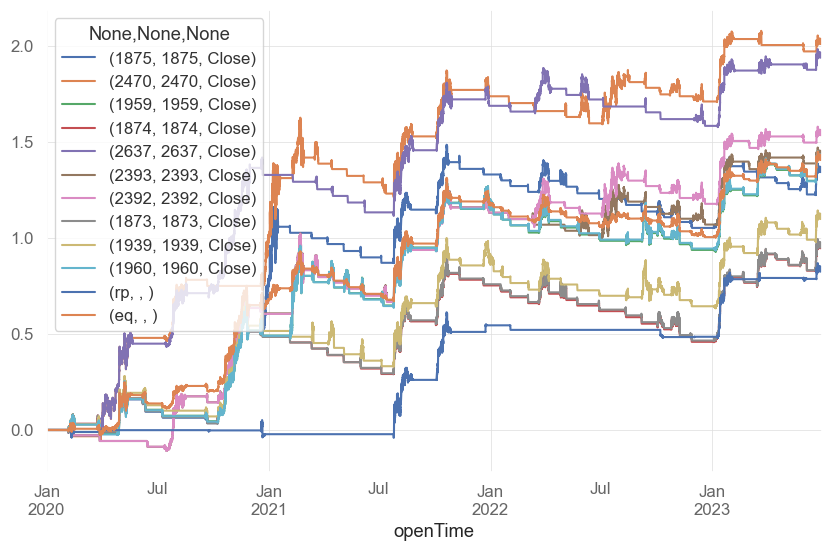

In [55]:
rett = portfolio.returns()

n = 72 * 6
rolling_risk = rett.rolling(n).std()
w_df_ = ((1/rolling_risk).T/(1/rolling_risk).sum(axis = 1)).T

rett['rp'] = (rett * w_df_).sum(axis=1)

rett['eq'] = rett.iloc[:, :10].mean(axis = 1) 

rett.cumsum().plot()

df_metrics = pd.DataFrame()
for col in rett.columns:
    df_metrics[col] = qs.reports.metrics(rett[col], mode='full', display=False, periods_per_year =4 * 24 * 365)

df_metrics.head(30)

<Axes: title={'center': 'Cumsum'}, xlabel='openTime'>

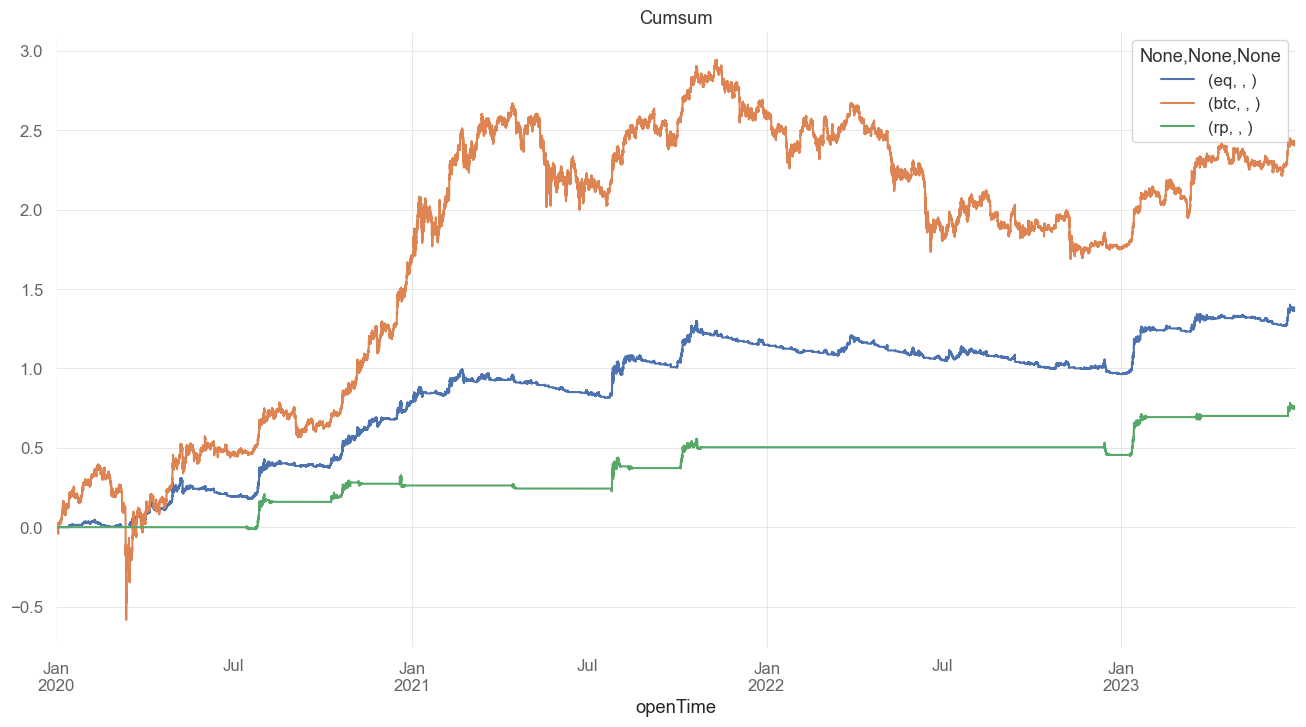

In [50]:
rett['btc'] = df['Close'].pct_change()
fig, ax = plt.subplots(figsize=(16,8))
rett[['eq', 'btc', 'rp']].cumsum().plot(ax=ax, title = 'Cumsum')